In [1]:
import cv2 as cv
import importlib
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw

import seaborn as sns
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_holes
import staintools
from staintools import stain_normalizer, LuminosityStandardizer
from staintools.preprocessing.input_validation import is_uint8_image
import sys

In [2]:
# Import HEMnet package
BASE_DIR = Path().resolve().parent
HEMNET_DIR = BASE_DIR.joinpath('HEMnet')
sys.path.append(str(HEMNET_DIR))

from slide import *
from utils import *

In [3]:
# User Input parameters
#SLIDES_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides/gold_standards')
SLIDES_PATH = Path('/gpfs1/scratch/90days/s4436005')
#OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/gold_standards/1957_T')
OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/train_dataset_10x_20_03_20_strict_iternorm')
#OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/train_dataset_10x_11_12_19_strict')
TEMPLATE_SLIDE_PATH = Path('/gpfs1/scratch/90days/s4436005/2171_T_11524A_2_HandE.svs')

ALIGNMENT_MAG = 2
TILE_MAG = 10
VERBOSE = True
CANCER_THRESH = 0.39
NON_CANCER_THRESH = 0.40
NORMALISER_METHOD = "vahadane"

#Verbose functions
if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
    verbose_save_fig = lambda fig, path, dpi=300: fig.savefig(path, dpi=dpi)
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None
    verbose_save_fig = lambda *args: None

# Find Slides
slides = []
for slide in SLIDES_PATH.glob('*.svs'):
    name = slide.name
    slides.append(name)
slides.sort()
slides

['1820_N_10545A_2_HandE.svs',
 '1820_N_10545A_4_TP53.svs',
 '1820_T_105452F_2_HandE.svs',
 '1820_T_105452F_4_TP53.svs',
 '2065_N_12752A_2_HandE.svs',
 '2065_N_12752A_4_TP53.svs',
 '2065_T_12756A_2_HandE.svs',
 '2065_T_12756A_4_TP53.svs',
 '2112_N_12341B_2_HandE.svs',
 '2112_N_12341B_4_TP53.svs',
 '2112_T_12335F_2_HandE.svs',
 '2112_T_12335F_4_TP53.svs',
 '2148_N_11397A_2_HandE.svs',
 '2148_N_11397A_4_TP53.svs',
 '2148_T_11393A_2_HandE.svs',
 '2148_T_11393A_4_TP53.svs',
 '2171_N_11521A_2_HandE.svs',
 '2171_N_11521A_4_TP53.svs',
 '2171_T_11524A_2_HandE.svs',
 '2171_T_11524A_4_TP53.svs']

In [4]:
TP53_slides = [slide for slide in slides if 'TP53' in slide]
HE_slides = [slide for slide in slides if 'HandE' in slide]
Paired_slides = list(zip(TP53_slides, HE_slides))
print('Found {0} pairs of slides'.format(len(Paired_slides)))
for i, pair in enumerate(Paired_slides):
    tp53, he = pair
    verbose_print('{0}. {1}|{2}'.format(i + 1, tp53, he))

Found 10 pairs of slides
1. 1820_N_10545A_4_TP53.svs|1820_N_10545A_2_HandE.svs
2. 1820_T_105452F_4_TP53.svs|1820_T_105452F_2_HandE.svs
3. 2065_N_12752A_4_TP53.svs|2065_N_12752A_2_HandE.svs
4. 2065_T_12756A_4_TP53.svs|2065_T_12756A_2_HandE.svs
5. 2112_N_12341B_4_TP53.svs|2112_N_12341B_2_HandE.svs
6. 2112_T_12335F_4_TP53.svs|2112_T_12335F_2_HandE.svs
7. 2148_N_11397A_4_TP53.svs|2148_N_11397A_2_HandE.svs
8. 2148_T_11393A_4_TP53.svs|2148_T_11393A_2_HandE.svs
9. 2171_N_11521A_4_TP53.svs|2171_N_11521A_2_HandE.svs
10. 2171_T_11524A_4_TP53.svs|2171_T_11524A_2_HandE.svs


In [5]:
metrics_df = pd.DataFrame((slides), columns = ["Slide_Name"])

In [6]:
metrics_df

,Slide_Name
0,1820_N_10545A_2_HandE.svs
1,1820_N_10545A_4_TP53.svs
2,1820_T_105452F_2_HandE.svs
3,1820_T_105452F_4_TP53.svs
4,2065_N_12752A_2_HandE.svs
5,2065_N_12752A_4_TP53.svs
6,2065_T_12756A_2_HandE.svs
7,2065_T_12756A_4_TP53.svs
8,2112_N_12341B_2_HandE.svs
9,2112_N_12341B_4_TP53.svs


In [7]:
SLIDE_NUM = 4
PREFIX = slides[SLIDE_NUM][:-4]
verbose_print('Processing Slide: {0}'.format(PREFIX))
slide_name = slides[SLIDE_NUM]
slide = open_slide(str(SLIDES_PATH.joinpath(slide_name)))

Processing Slide: 2065_N_12752A_2_HandE


In [8]:
# #Load Slides
# he = read_slide_at_mag(he_slide, ALIGNMENT_MAG)
# tp53 = read_slide_at_mag(tp53_slide, ALIGNMENT_MAG)

In [9]:
slide.level_downsamples

(1.0, 4.0001719448190425, 16.002249086207662)

In [10]:
slide.level_dimensions

((53783, 33125), (13445, 8281), (3361, 2070))

In [11]:
for i in range(20):
    SLIDE_NUM = i
    PREFIX = slides[SLIDE_NUM][:-4]
    verbose_print('Processing Slide: {0}'.format(PREFIX))
    slide_name = slides[SLIDE_NUM]
    slide = open_slide(str(SLIDES_PATH.joinpath(slide_name)))
    #Pixel Area
    slide_px_area = slide.dimensions[0]*slide.dimensions[1]
    slide_px_area
    metrics_df.loc[SLIDE_NUM, "Pixel_Area"] = slide_px_area
    #MPP is microns-per-pixel
    slide_mpp = float(slide.properties['aperio.MPP'])
    metrics_df.loc[SLIDE_NUM, "MPP"] = slide_mpp
    #Slide Area in square mm
    slide_area_mm = slide_px_area*(slide_mpp*10**-3)**2
    metrics_df.loc[SLIDE_NUM, "Area_mm"] = slide_area_mm

Processing Slide: 1820_N_10545A_2_HandE
Processing Slide: 1820_N_10545A_4_TP53
Processing Slide: 1820_T_105452F_2_HandE
Processing Slide: 1820_T_105452F_4_TP53
Processing Slide: 2065_N_12752A_2_HandE
Processing Slide: 2065_N_12752A_4_TP53
Processing Slide: 2065_T_12756A_2_HandE
Processing Slide: 2065_T_12756A_4_TP53
Processing Slide: 2112_N_12341B_2_HandE
Processing Slide: 2112_N_12341B_4_TP53
Processing Slide: 2112_T_12335F_2_HandE
Processing Slide: 2112_T_12335F_4_TP53
Processing Slide: 2148_N_11397A_2_HandE
Processing Slide: 2148_N_11397A_4_TP53
Processing Slide: 2148_T_11393A_2_HandE
Processing Slide: 2148_T_11393A_4_TP53
Processing Slide: 2171_N_11521A_2_HandE
Processing Slide: 2171_N_11521A_4_TP53
Processing Slide: 2171_T_11524A_2_HandE
Processing Slide: 2171_T_11524A_4_TP53


In [12]:
metrics_df

,Slide_Name,Pixel_Area,MPP,Area_mm
0,1820_N_10545A_2_HandE.svs,2.246171e+09,0.4941,548.368481
1,1820_N_10545A_4_TP53.svs,2.245709e+09,0.4941,548.255780
2,1820_T_105452F_2_HandE.svs,1.703325e+09,0.4941,415.840924
3,1820_T_105452F_4_TP53.svs,2.039530e+09,0.4941,497.920167
4,2065_N_12752A_2_HandE.svs,1.781562e+09,0.4941,434.941270
5,2065_N_12752A_4_TP53.svs,1.678824e+09,0.4941,409.859351
6,2065_T_12756A_2_HandE.svs,1.547148e+09,0.4941,377.712577
7,2065_T_12756A_4_TP53.svs,1.474512e+09,0.4941,359.979824
8,2112_N_12341B_2_HandE.svs,2.997868e+09,0.4941,731.883917
9,2112_N_12341B_4_TP53.svs,2.636985e+09,0.4941,643.779928


In [13]:
metrics_df.describe()

,Pixel_Area,MPP,Area_mm
count,2.000000e+01,2.000000e+01,20.000000
mean,2.230794e+09,4.941000e-01,544.614475
std,4.788008e+08,1.139065e-16,116.891947
min,1.474512e+09,4.941000e-01,359.979824
25%,1.848944e+09,4.941000e-01,451.391648
50%,2.245940e+09,4.941000e-01,548.312131
75%,2.567767e+09,4.941000e-01,626.881293
max,3.007573e+09,4.941000e-01,734.253374


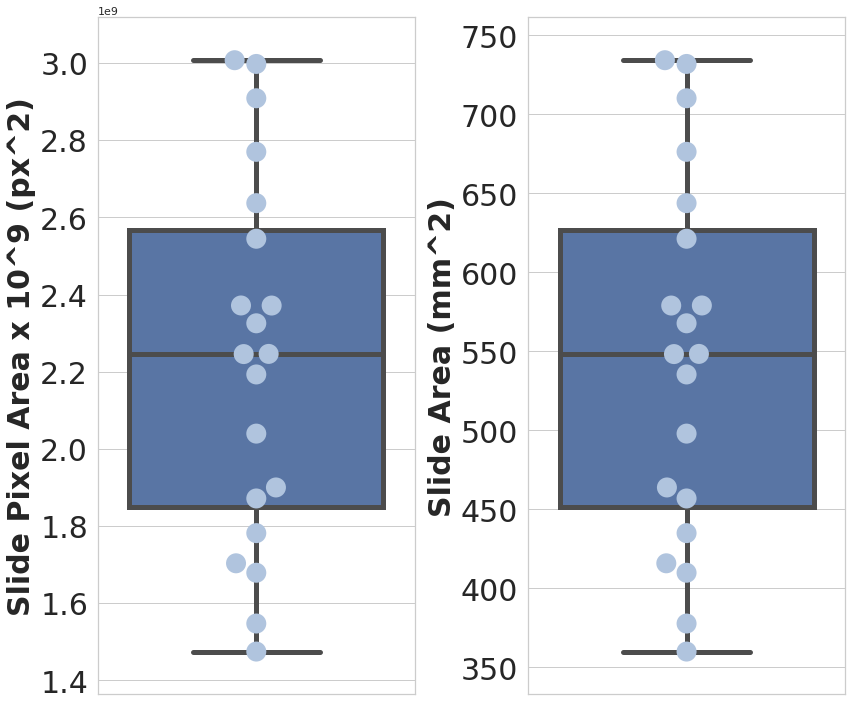

In [76]:
sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,10))
#sns.violinplot(y=metrics_df["Pixel_Area"], ax = ax1)
#sns.violinplot(y= metrics_df["Area_mm"], ax = ax2)
sns.boxplot(y=metrics_df["Pixel_Area"], ax = ax1, linewidth = 5)
sns.boxplot(y= metrics_df["Area_mm"], ax = ax2, linewidth = 5)
sns.swarmplot(y=metrics_df["Pixel_Area"], ax = ax1, color = "lightsteelblue", edgecolor = "0.2", linewidth=0, size = 20)
sns.swarmplot(y=metrics_df["Area_mm"], ax = ax2, color = "lightsteelblue", edgecolor = "0.2", linewidth=0, size = 20)
ax1.tick_params(labelsize = 30)
ax1.set_ylabel("Slide Pixel Area x 10^9 (px^2)", fontsize = 30, weight="semibold")
#ax1.grid(linewidth = 3)
ax2.tick_params(labelsize = 30)
ax2.set_ylabel("Slide Area (mm^2)", fontsize = 30, weight="semibold")
fig.tight_layout()
fig.show()